In [1]:
import pandas as pd
import numpy as np

In [2]:
def custom_date_parser(x):
    # Remove the " IST" portion if present.
    x = x.replace(" IST", "")
    
    # If the string contains a fractional seconds part, process it.
    if '.' in x:
        date_part, frac_and_tz = x.split('.', 1)
        parts = frac_and_tz.split(' ', 1)
        frac = parts[0]
        tz = parts[1] if len(parts) > 1 else ""
        
        # Truncate fractional seconds to 9 digits (seconds)
        frac = frac[:9].ljust(9, '0')
        x = f"{date_part}.{frac} {tz}"
        date_format = "%Y-%m-%d %H:%M:%S.%f %z"
    else:
        date_format = "%Y-%m-%d %H:%M:%S"
    
    return pd.to_datetime(x, format=date_format)

# --- File Paths ---
depth_file = "depth20_10001.csv"
aggtrade_file = "aggTrade1.csv"

# --- STEP 1: Load Data as strings (without automatic date parsing) ---
depth_df = pd.read_csv(depth_file)  # Time will be read as string
agg_df = pd.read_csv(aggtrade_file)


In [3]:
# --- STEP 2: Manually parse the Time column using our custom_date_parser ---
depth_df['Time'] = depth_df['Time'].apply(custom_date_parser)
agg_df['Time'] = agg_df['Time'].apply(custom_date_parser)

# Sort both dataframes by Time.
depth_df = depth_df.sort_values("Time").reset_index(drop=True)
agg_df = agg_df.sort_values("Time").reset_index(drop=True)

print(depth_df)
print(agg_df)

                                     Time  BidPriceL20  BidQtyL20  \
0     2025-03-14 00:00:02.292522546+05:30       579.20      0.621   
1     2025-03-14 00:00:03.292828523+05:30       579.08      2.612   
2     2025-03-14 00:00:04.292889586+05:30       579.14      1.948   
3     2025-03-14 00:00:05.292551566+05:30       579.07      0.013   
4     2025-03-14 00:00:06.292725093+05:30       579.11      9.143   
...                                   ...          ...        ...   
85350 2025-03-14 23:59:54.292671488+05:30       585.49      3.508   
85351 2025-03-14 23:59:55.292427075+05:30       585.51      4.271   
85352 2025-03-14 23:59:56.292630843+05:30       585.50      3.422   
85353 2025-03-14 23:59:57.292942801+05:30       585.51      4.271   
85354 2025-03-14 23:59:58.292470760+05:30       585.51      4.271   

       BidPriceL19  BidQtyL19  BidPriceL18  BidQtyL18  BidPriceL17  BidQtyL17  \
0           579.24      0.015       579.25      0.009       579.26      0.013   
1        

In [4]:
# --- STEP 3: Align aggTrade events with the most recent order book snapshot ---
# Use merge_asof to merge the latest depth snapshot with each trade event.
merged = pd.merge_asof(agg_df, 
                       depth_df,
                       on="Time",
                       direction="backward",
                       suffixes=("", "_Depth"))

In [5]:
# --- STEP 4: Compute Features Based on the Merged Data ---
def label_aggressive_side(row):
    # Check for missing data in top-of-book prices
    if pd.isna(row.get('AskPriceL1')) or pd.isna(row.get('BidPriceL1')):
        return "Unknown"
    # Aggressive buy if trade executed at or above best ask; aggressive sell if at or below best bid.
    if row['Price'] >= row['AskPriceL1']:
        return "Buy"
    elif row['Price'] <= row['BidPriceL1']:
        return "Sell"
    else:
        return "Passive"

merged['AggressiveSide'] = merged.apply(label_aggressive_side, axis=1)

def compute_top_level_remaining(row):
    if row['AggressiveSide'] == "Buy":
        return row['AskQtyL1'] - row['Quantity']
    elif row['AggressiveSide'] == "Sell":
        return row['BidQtyL1'] - row['Quantity']
    else:
        return np.nan

merged['TopLevelQtyRemaining'] = merged.apply(compute_top_level_remaining, axis=1)

# Additional feature: compute the bid-ask spread.
merged['Spread'] = merged['AskPriceL1'] - merged['BidPriceL1']

Merged data saved to merged_depth20_aggTrade.csv


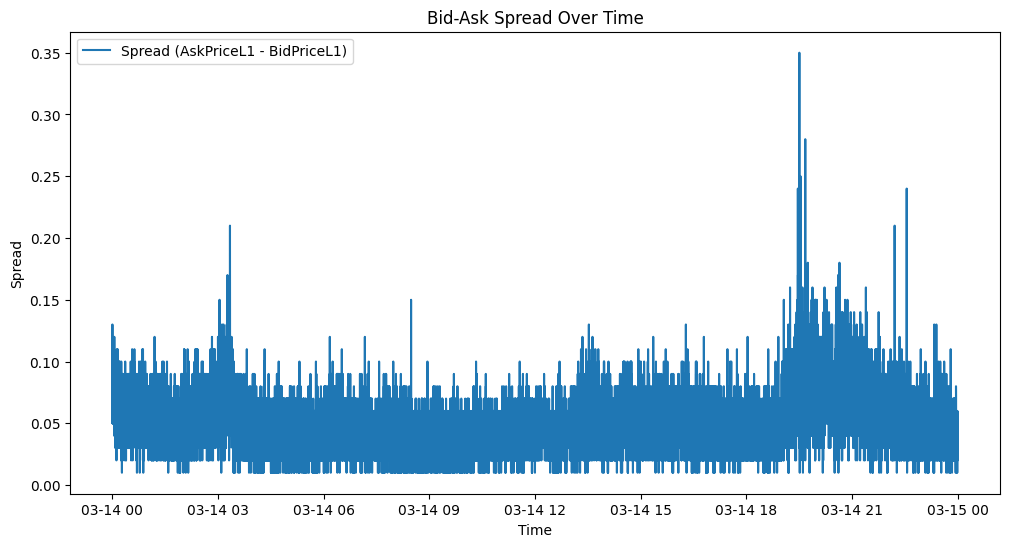

In [7]:
# --- STEP 5: Save the Merged Data for Further Analysis ---
merged.to_csv("merged_depth20_aggTrade.csv", index=False)
print("Merged data saved to merged_depth20_aggTrade.csv")

#Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.plot(merged['Time'], merged['Spread'], label='Spread (AskPriceL1 - BidPriceL1)')
plt.xlabel("Time")
plt.ylabel("Spread")
plt.title("Bid-Ask Spread Over Time")
plt.legend()
plt.show()

In [8]:
# Order book features:
# merged['spread'] = merged['AskPriceL1'] - merged['BidPriceL1']
merged['imbalance_lvl1'] = (merged['BidQtyL1'] - merged['AskQtyL1']) / (merged['BidQtyL1'] + merged['AskQtyL1'])
merged['microprice'] = (merged['BidPriceL1']*merged['AskQtyL1'] + merged['AskPriceL1']*merged['BidQtyL1']) / (merged['BidQtyL1'] + merged['AskQtyL1'])

# Cumulative depth:
bid_qty_cols = [f'BidQtyL{i}' for i in range(1, 21)]
ask_qty_cols = [f'AskQtyL{i}' for i in range(1, 21)]
merged['cum_bid_qty'] = merged[bid_qty_cols].sum(axis=1)
merged['cum_ask_qty'] = merged[ask_qty_cols].sum(axis=1)

# Derived example: Sloped depth (average gradient across levels)
bid_gradient = np.gradient(merged[bid_qty_cols], axis=1)
ask_gradient = np.gradient(merged[ask_qty_cols], axis=1)
merged['bid_slope'] = bid_gradient.mean(axis=1)
merged['ask_slope'] = ask_gradient.mean(axis=1)

# Make sure 'Time' is converted to datetime and set as the index
merged['Time'] = pd.to_datetime(merged['Time'])
merged = merged.sort_values('Time').set_index('Time')

#Compute the mid-price as the average of the best bid and best ask prices.
merged['mid_price'] = (merged['BidPriceL1'] + merged['AskPriceL1']) / 2
merged['log_return'] = np.log(merged['mid_price'] / merged['mid_price'].shift(1)) #Compute log returns of the mid-price.
merged['volatility_10s'] = merged['log_return'].rolling('10s').std() #Calculate rolling volatility (standard deviation of log returns)
merged['volatility_30s'] = merged['log_return'].rolling('30s').std()

merged['cum_volume_10s'] = merged['Quantity'].rolling('10s').sum() #Compute rolling cumulative volume if you have trade volume data in 'Quantity'
merged['cum_volume_30s'] = merged['Quantity'].rolling('30s').sum()


print(merged[['Spread','imbalance_lvl1','microprice','cum_bid_qty','cum_ask_qty','bid_slope','ask_slope', 'mid_price', 'log_return', 'volatility_10s', 'volatility_30s', 'cum_volume_10s', 'cum_volume_30s']].head())

                                     Spread  imbalance_lvl1  microprice  \
Time                                                                      
2025-03-14 00:00:02.764823793+05:30    0.08             0.0      579.48   
2025-03-14 00:00:02.781509697+05:30    0.08             0.0      579.48   
2025-03-14 00:00:02.805731800+05:30    0.08             0.0      579.48   
2025-03-14 00:00:03.902576812+05:30    0.08             0.0      579.40   
2025-03-14 00:00:03.905083833+05:30    0.08             0.0      579.40   

                                     cum_bid_qty  cum_ask_qty  bid_slope  \
Time                                                                       
2025-03-14 00:00:02.764823793+05:30       57.149       29.514  -0.008575   
2025-03-14 00:00:02.781509697+05:30       57.149       29.514  -0.008575   
2025-03-14 00:00:02.805731800+05:30       57.149       29.514  -0.008575   
2025-03-14 00:00:03.902576812+05:30       88.726       30.428   0.022525   
2025-03-14 00:00:0

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select feature columns for clustering
features = merged[['Spread', 'imbalance_lvl1', 'microprice', 'cum_bid_qty', 'cum_ask_qty', 'bid_slope', 'ask_slope', 'cum_volume_10s', 'cum_volume_30s']]
scaler = StandardScaler()  #z-score normalization
features_scaled = scaler.fit_transform(features)

# Optionally, reduce dimensionality to 3-5 principal components:
pca = PCA(n_components=5)
features_pca = pca.fit_transform(features_scaled)


# Subsample for silhouette score (e.g., 10k samples)
np.random.seed(42)
subsample_idx = np.random.choice(len(features_pca), size=min(10000, len(features_pca)), replace=False)
sample_data = features_pca[subsample_idx]

# You can inspect the transformed features:
print("Mean of each feature (should be close to 0):", features_scaled.mean(axis=0))
print("Standard Deviation (should be 1):", features_scaled.std(axis=0))

Mean of each feature (should be close to 0): [ 2.10572961e-17  0.00000000e+00  2.63035711e-14 -4.20393876e-16
 -3.33908553e-16 -4.17385691e-17  4.06104997e-17 -1.93275897e-16
 -2.82769405e-16]
Standard Deviation (should be 1): [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go

# 1. Extract cummulative_volume_10s data from your `merged` DataFrame
volume_df = merged[['cum_volume_10s']].copy().head(10000)
volume_df.columns.name = 'cum_volume_10s'  # Set the column name for reference



# 2. Prepare data: moving average + log return
def prepare_data_for_model_input(prices, ma):
    instrument = prices.columns.name if prices.columns.name else prices.columns[0]

    prices[f'{instrument}_ma'] = prices.rolling(ma).mean()
    prices[f'{instrument}_log_return'] = np.log(prices[f'{instrument}_ma'] / prices[f'{instrument}_ma'].shift(1))

    prices.dropna(inplace=True)
    prices_array = prices[[f'{instrument}_log_return']].values  # shape: (N, 1)
    
    return prices, prices_array

prices, prices_array = prepare_data_for_model_input(volume_df, ma=7)




# 3. Clustering class
class RegimeDetection:
    def get_regimes_clustering(self, params):
        model = self.initialise_model(AgglomerativeClustering(), params)
        return model

    def initialise_model(self, model, params):
        for param, value in params.items():
            setattr(model, param, value)
        return model

# 4. Plotting function
def plot_hidden_states(hidden_states, prices_df):
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()

    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State', i, ":", mask.sum())
        
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],
            y=prices_df[f"{prices_df.columns.name}"][mask],
            mode='markers',
            name='Hidden State ' + str(i),
            marker=dict(size=4, color=colors[i % len(colors)])
        ))
    
    fig.update_layout(
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    )
    fig.show()

# 5. Run clustering
#State 0	Quiet / Range-bound / consolidation
#State 1	Volatile / Trending / high volume
params = {
    'n_clusters': 2,
    'linkage': 'complete',
    'metric': 'manhattan'  # Use 'metric', NOT 'affinity'
}

regime_detection = RegimeDetection()
clustering_model = regime_detection.get_regimes_clustering(params)
clustering_states = clustering_model.fit_predict(prices_array)

# 6. Plot
plot_hidden_states(clustering_states, prices[['cum_volume_10s']])


Number of observations for State 0 : 278
Number of observations for State 1 : 9715


In [ ]:
from sklearn.cluster import AgglomerativeClustering


# 1. Extract cumulative volume data
volume_df = merged[['cum_volume_10s']].copy().head(10000)
volume_df.columns.name = 'cum_volume_10s'  # Set the column name for reference

# 2. Use raw data directly for clustering
prices_array = volume_df.values  # shape: (N, 1)

# 3. Clustering class
class RegimeDetection:
    def get_regimes_clustering(self, params):
        model = self.initialise_model(AgglomerativeClustering(), params)
        return model

    def initialise_model(self, model, params):
        for param, value in params.items():
            setattr(model, param, value)
        return model

# 4. Plotting function
def plot_hidden_states(hidden_states, prices_df):
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()

    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State', i, ":", mask.sum())
        
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],
            y=prices_df[f"{prices_df.columns.name}"][mask],
            mode='markers',
            name='Hidden State ' + str(i),
            marker=dict(size=4, color=colors[i % len(colors)])
        ))
    
    fig.update_layout(
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    )
    fig.show()

# 5. Run clustering
params = {
    'n_clusters': 2,
    'linkage': 'complete',
    'metric': 'manhattan'
}

regime_detection = RegimeDetection()
clustering_model = regime_detection.get_regimes_clustering(params)
clustering_states = clustering_model.fit_predict(prices_array)

# 6. Plot the clustering result
plot_hidden_states(clustering_states, volume_df)


Number of observations for State 0 : 9841
Number of observations for State 1 : 159


In [ ]:
# 1. Prepare data
volume_df = merged[['cum_volume_10s']].copy().head(10000)
volume_df.columns.name = 'cum_volume_10s'

price_df = merged[['Price']].copy().head(10000)  # Use your actual price column
price_df.columns.name = 'Price'

# 2. Clustering on raw volume
prices_array = volume_df.values


# 3. Regime Detection Class
class RegimeDetection:
    def get_regimes_clustering(self, params):
        model = self.initialise_model(AgglomerativeClustering(), params)
        return model

    def initialise_model(self, model, params):
        for param, value in params.items():
            setattr(model, param, value)
        return model



# 4. Plotting: Regimes on both volume and price
def plot_regimes_on_volume_and_price(hidden_states, volume_df, price_df):
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    n_components = len(np.unique(hidden_states))
    
    fig = go.Figure()
    
    for i in range(n_components):
        mask = hidden_states == i
        print(f"Number of observations for State {i}: {mask.sum()}")
        
        # Volume regime
        fig.add_trace(go.Scatter(
            x=volume_df.index[mask],
            y=volume_df.iloc[mask, 0],
            mode='markers',
            name=f'Volume State {i}',
            marker=dict(size=4, color=colors[i % len(colors)]),
            yaxis='y1'
        ))

        # Overlay price regime
        fig.add_trace(go.Scatter(
            x=price_df.index[mask],
            y=price_df.iloc[mask, 0],
            mode='markers',
            name=f'Price in State {i}',
            marker=dict(size=3, symbol='x', color=colors[i % len(colors)]),
            yaxis='y2',
            showlegend=False
        ))

    # Layout with dual axis
    fig.update_layout(
        title='Volume-Based Regimes with Price Overlay',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Volume', side='left'),
        yaxis2=dict(title='Price', overlaying='y', side='right'),
        height=500,
        width=1000,
        legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.01),
        margin=dict(l=30, r=30, t=40, b=30)
    )
    fig.show()


# 3. Plot with background regime bands
def plot_regimes_with_background(hidden_states, volume_df, price_df):
    colors = ['rgba(135,206,250,0.2)', 'rgba(255,160,122,0.2)', 'rgba(144,238,144,0.2)']  # light blue, salmon, green

    fig = go.Figure()

    # Price line
    fig.add_trace(go.Scatter(
        x=price_df.index,
        y=price_df.iloc[:, 0],
        mode='lines',
        name='Price',
        line=dict(color='black')
    ))

    # Volume line
    fig.add_trace(go.Scatter(
        x=volume_df.index,
        y=volume_df.iloc[:, 0],
        mode='lines',
        name='Volume',
        line=dict(color='orange'),
        yaxis='y2'
    ))

    # Identify continuous regime segments
    prev_state = hidden_states[0]
    start_idx = 0
    for i in range(1, len(hidden_states)):
        if hidden_states[i] != prev_state:
            start_time = volume_df.index[start_idx]
            end_time = volume_df.index[i]
            fig.add_vrect(
                x0=start_time, x1=end_time,
                fillcolor=colors[prev_state % len(colors)],
                layer='below', line_width=0
            )
            start_idx = i
            prev_state = hidden_states[i]
    # Last segment
    fig.add_vrect(
        x0=volume_df.index[start_idx], x1=volume_df.index[-1],
        fillcolor=colors[prev_state % len(colors)],
        layer='below', line_width=0
    )

    # Layout
    fig.update_layout(
        title='Volume Regimes with Background Bands (Agglomerative Clustering)',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Price', side='left'),
        yaxis2=dict(title='Volume', overlaying='y', side='right', showgrid=False),
        legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.01),
        height=600,
        width=1000,
        margin=dict(l=30, r=30, t=40, b=30)
    )
    fig.show()


# 5. Fit model
params = {
    'n_clusters': 2,
    'linkage': 'complete',
    'metric': 'manhattan'
}

regime_detection = RegimeDetection()
clustering_model = regime_detection.get_regimes_clustering(params)
clustering_states = clustering_model.fit_predict(prices_array)

# 6. Plot result
plot_regimes_on_volume_and_price(clustering_states, volume_df, price_df)
plot_regimes_with_background(clustering_states, volume_df, price_df)


Number of observations for State 0: 9841
Number of observations for State 1: 159


In [ ]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# 1. Extract and prepare spread data
spread_df = merged[['cum_volume_10s']].copy().head(10000)
spread_df.columns.name = 'cum_volume_10s'  # for plot labeling

# 2. Feature Engineering: moving average & log return
def prepare_data_for_model_input(prices, ma):
    instrument = prices.columns.name if prices.columns.name else prices.columns[0]

    prices[f'{instrument}_ma'] = prices.rolling(ma).mean()
    prices[f'{instrument}_log_return'] = np.log(prices[f'{instrument}_ma'] / prices[f'{instrument}_ma'].shift(1))

    prices.dropna(inplace=True)
    prices_array = prices[[f'{instrument}_log_return']].values
    
    return prices, prices_array

prices, prices_array = prepare_data_for_model_input(spread_df, ma=7)

# 3.Clustering Class updated for KMean
class RegimeDetection:
    def get_regimes_clustering(self, params):
        model = self.initialise_model(KMeans(), params)
        return model

    def initialise_model(self, model, params):
        for param, value in params.items():
            setattr(model, param, value)
        return model

# 4. Plotting function (same as before)
def plot_hidden_states(hidden_states, prices_df):
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()

    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State', i, ":", mask.sum())
        
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],
            y=prices_df[f"{prices_df.columns.name}"][mask],
            mode='markers',
            name='Hidden State ' + str(i),
            marker=dict(size=4, color=colors[i % len(colors)])
        ))
    
    fig.update_layout(
        height=400, width=900,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        margin=dict(l=20, r=20, t=20, b=20)
    )
    fig.show()

# 5. Run KMeans clustering
params = {
    'n_clusters': 2,
    'random_state': 42
}

regime_detection = RegimeDetection()
clustering_model = regime_detection.get_regimes_clustering(params)
clustering_states = clustering_model.fit_predict(prices_array)

# 6. Plot
plot_hidden_states(clustering_states, prices[['cum_volume_10s']])


c:\Users\Mritunjay Maddhesiya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Number of observations for State 0 : 8749
Number of observations for State 1 : 1244
